In [110]:
from datetime import datetime, timedelta
from typing import List
import requests as req
from statistics import mean
from pandas import DataFrame
import matplotlib.pyplot as plt


In [111]:
class ChartCollectorAPI():
    def __init__(self):
        self.charts={}
        # Lits of available API keys (formed in dictionnary)
        self.apiKeys= [
            {'x-api-key': "cS9O1Mqm4paU5TgBBBCDb3K0YkZNY1YC19Wd4Ia1"},
            {'x-api-key': "ZQMMFwwABB4aJiyLvqAon6sIHcpztSgt7h0DV7Iv"},
            {'x-api-key': "kmS8VNRGnG8RH3dMAIkQq7SEMtAE6QGp4FqgGlOm"},
            {'x-api-key': "LgEsoJrl6o6my9g46Xk3y5hYcEEZJyhA3aknepFP"},
            {'x-api-key': "x0lGuGoAQMvr9Uweu7y62z0TwB0rHIx8eSxPwsV4"},
            {'x-api-key': "mTd2MNVwEe3WFgj5PQ66Tbpq0CyeP8Q7ESjpmYZ2"},]
        
    def get_chart(self,symbol:str,charts:List[str]=None,range:str="1mo",distance_of_data_from_today_in_days:int=0) -> list:
        # We try each and every key defined inside apiKeys (the list of keys)
        for apiKey in self.apiKeys:
            
            # We tell the user which key is currently used to make the request
            print(f"API Key used :{apiKey['x-api-key']}")
            
            # The header is the api key as a dict ({'x-api-key': "XXX"}) it is defined by Yahoo Finance
            headers = apiKey
        
            # Here is the start of the url used for the request
            url = f"https://yfapi.net/v8/finance/chart/{symbol}?"
            
            # If we defined charts variable (list of symbols) the we concatenate them to the url respecting the Yahoo API documentation (adding %2C between each symbol)
            if charts:
                # We add "comparisons=" to the url (defined by the Yahoo API documentation) it allows us to collect more symbols data
                url += "comparisons="
                for asset in charts:
                    url+= asset
                    if asset != (len(charts) - 1):
                        url+="%2C"
                url += "&"
                
                
            # Here we add the end of the url defining the correct range, region, interval between close values, language and specify the event (how to understand and separate every comparison symbol)
            url+=f"range={range}&region=US&interval=1d&lang=en&events=div%2Csplit"
            
            # We send the GET request to the Yahoo API
            response = req.request("GET", url, headers=headers)
            
            try:
                # We try to collect the response. If there is an error, it means that the request failed (most of the time because of request exceeding the limit)
                response = response.json()["chart"]["result"][0]
                
                # We collect timestamps 
                timesamps = response["timestamp"]
                # We get the reference graph (close values)
                reference = response["indicators"]["quote"][0]["close"]
                
                # Adding reference chart
                if symbol not in self.charts and None not in reference:
                    print(symbol)
                    self.charts[symbol]=[{"date":datetime.fromtimestamp(int(timestamp)), "close":close} for timestamp, close in zip(timesamps, reference) if abs(datetime.now()-datetime.fromtimestamp(int(timestamp)) >timedelta(days = distance_of_data_from_today_in_days))]
                
                
                if charts:
                    comparison = response["comparisons"]
                    # Adding the comparisons charts
                    for value in comparison:
                        symbol = value["symbol"]
                        print(symbol)
                        if symbol not in self.charts and None not in value["close"]:
                            self.charts[symbol]=[{"date":datetime.fromtimestamp(int(timestamp)), "close":close} for timestamp, close in zip(timesamps, value["close"]) if abs(datetime.now()-datetime.fromtimestamp(int(timestamp)) >timedelta(days = distance_of_data_from_today_in_days))]
                        elif symbol in self.charts:
                            print (f"{symbol} already loaded")
                        else:
                            print(f"{symbol} contains None values")

                return # If there is no exception raised, it means we managed to get the data

            except Exception as exception:
                try:
                    print(response.json())
                except Exception as error:
                    print(f"unable to get response {error}")
                print(f"Trying with another api key... {exception}") # We continue the for loop
                
        print("There is no valid API key remaining ! ") # If there is no element in the for loop, we exit and tell the user the data hasn't been loaded

    """Method to load saved charts from another object (used to save data in the notebook)
    """
    def loading(self,charts):
        self.charts=charts
        
    """Method to save all the results from the point to point analysis using the reference asset.
    params : reference asset, charts including reference data, data_length corresponding to the length of graphs
    returns : dict with distance result and current data, next data for comparison and reference charts.
    """
    def resultats_rapports(self,reference_asset,charts,data_length:int=21,timeframe:int = 7) -> dict:
        # Get the date of the first reference value
        date_reference = charts[reference_asset][-(data_length+timeframe)]['date']

        # Get all the close values of length data_length to timeframe from the end
        chart_reference = [value['close'] for value in charts[reference_asset]][-(data_length+timeframe):-timeframe]

        #  Get the closed values at timeframe from the end of chart_reference (the last one) to the end
        chart_reference_current_data = [value['close'] for value in charts[reference_asset]][-timeframe:]

        results = []

        # For all the other charts
        for comparison_asset in charts:
            # If it is another asset we can continue
            if comparison_asset != reference_asset:
                
                # comparison is the charts we are comparing with reference, and curren_data corresponds to the value at timeframe after the last comparison value used for the prediction
                for index in range(len(charts[comparison_asset])-(data_length+timeframe)):

                    comparison = [value["close"] for value in charts[comparison_asset][index:index+data_length]]
                    # Compares the data length of reference chart and comparison chart to ensure we can use the point to point comparison.
                    if len(comparison) ==len(chart_reference):
                        try:
                            distance = self.distance_point_to_point(chart_reference,comparison)
                        except Exception as error:
                            print(f"Erreur sur le rapport moyenne {reference_asset} /  {comparison_asset} : {error} ")
                            raise error
                        
                        # If there is a IndexError raised, it means we are not able to give the current number for the prediction (comparison chart)
                        try:
                            results.append({ #f string to create a distinct dictionnary value
                                "value":distance,
                                "reference_asset":reference_asset,
                                "comparison_asset":comparison_asset,
                                "chart_reference":chart_reference, # starts at data_length+timeframe values from the last fetched value
                                "chart_comparison":comparison,
                                "current_data_comparison":[value["close"] for value in charts[comparison_asset][index+data_length:index+data_length+timeframe]],
                                "current_data_reference":chart_reference_current_data, # value at timeframe values after the last reference chart value
                                "date_reference":date_reference, # date of the first value of reference chart
                                "date_comparison":charts[comparison_asset][index]["date"], # date of the first value of comparison chart
                                })
                        except IndexError:
                            # Change asset if there is an error with the current one
                            break
        self.predictions=results

        return results
    
    def distance_point_to_point(self,chart_reference,chart_comparison):          
        
        
        # We compare charts by reducing them to the mean.
        try:
            rearange_reference = [value / mean(chart_reference) for value in chart_reference]
        except Exception:
            print(chart_reference)
            
        try:
            rearange_comparison = [value / mean(chart_comparison) for value in chart_comparison]
        except Exception:
            print(chart_comparison)

        # We calculate the relative point to point distance
        distances = [
            abs(rearange_reference[i] - rearange_comparison[i])
            for i in range(len(rearange_reference))
        ]
        return sum(distances)

    """Method to generate the analysis and to sort it
    returns : sorted analysis
    """
    def comparison(self,symbol:str,data_length:int=21,timeframe:int = 7):
        result = self.resultats_rapports(reference_asset=symbol,charts=self.charts,data_length=data_length,timeframe=timeframe)
        result.sort(key=lambda t: t["value"])
        
        # Removes the occurences of the first chart
        for i in range(5):
            best = result[i]
            result = list(filter(lambda t: abs(t["date_comparison"]-result[i]["date_comparison"])>timedelta(days = 30) or t["comparison_asset"]!=result[i]["comparison_asset"] , result))
            result.insert(i,best)
        return result

    """Method to go through the analysis and output a prediction
    returns : average predicted price for the asset
    """
    def predict(self,sortedComparaison,nb_choice)->float:
        # Get the nb_choice charts best matching with the reference one
        sorted_best_choice = sortedComparaison[:nb_choice]

        # Saves the best matching chart
        self.best_prediction = sorted_best_choice[0]
        
        current_data_reference = sorted_best_choice[0]["current_data_reference"][-1]
        chart_reference = sorted_best_choice[0]["chart_reference"]
        


        prediction_list = [value["current_data_comparison"][-1]/value["chart_comparison"][-1]*chart_reference[-1] for value in sorted_best_choice]

        # The prediction value is the mean of all the predicted values
        prediction = mean(prediction_list)      

        # Calculate the error
        print(f"{nb_choice} : {abs(1-prediction/current_data_reference)*100}%")
        return prediction
    

    def plot_prediction(self,):
        if not self.best_prediction:
            print("There is no prediction to plot")
            return

        best_choice = self.best_prediction
        # On créé une nouvelle figure pour afficher le premier graphique
        Figure = plt.figure(figsize=(5,5), dpi=100)
        ax = Figure.add_subplot(111)
        ax.yaxis.label.set_color('red')

        # REFERENCE
        # On recupere les dates et les price de l'actif 1
        dates = list(range(len(best_choice["chart_reference"])))

        # On recupere les dates et les price de l'actif 1 ce qui s'est reellement passé 
        price = best_choice["chart_reference"]

        #####
        #price = [value / mean(best_choice["chart_reference"]) for value in best_choice["chart_reference"]]
        ###

        # On crée un DataFrame pendant pour le plot plus facilement
        df = DataFrame({"dates":dates,best_choice["reference_asset"]:price},columns=[best_choice["reference_asset"],'dates'])

        # On regroupe les price par dates
        df = df[['dates',best_choice["reference_asset"]]].groupby('dates').sum()

        # On affiche le dataframe
        df.plot(kind='line', legend=True, ax=ax, color='r')

        # On recupere les dates et les price de l'actif 1 ce qui s'est reellement passé 
        price = best_choice["current_data_reference"]


        #####
        #price = [value / mean(best_choice["current_data_reference"]) for value in best_choice["current_data_reference"]]
        ###

        dates = list(range(len(best_choice["chart_reference"]), len(best_choice["chart_reference"]) + len(best_choice["current_data_reference"])))


        # On crée un DataFrame pendant pour le plot plus facilement
        df = DataFrame({"dates":dates,best_choice["reference_asset"]:price},columns=[best_choice["reference_asset"],'dates'])

        # On regroupe les price par dates
        df = df[['dates',best_choice["reference_asset"]]].groupby('dates').sum()

        # On affiche le dataframe
        df.plot(linestyle='dashed',kind='line', legend=True, ax=ax, color='r')



        # COMPARAISON
        # On decoupe les ordonnées en deux categories distinctes pour les visualiser correctement
        ax2 = ax.twinx()
        # On change la couleur du label des ordonnées
        ax2.yaxis.label.set_color('b')

        # On recupere les dates et les price de l'actif 2
        price = best_choice["chart_comparison"]

        #####
        #price = [value / mean(best_choice["chart_comparison"]) for value in best_choice["chart_comparison"]]
        ###

        # On recupere les dates et les price de l'actif 2
        dates = list(range(len(best_choice["chart_comparison"])))
        # On crée un DataFrame pendant pour le plot plus facilement
        df = DataFrame({"dates":dates,best_choice["comparison_asset"]:price},columns=[best_choice["comparison_asset"],'dates'])
        # On regroupe les price par dates
        df = df[['dates',best_choice["comparison_asset"]]].groupby('dates').sum()
        # On affiche le dataframe
        df.plot(kind='line', legend=True, ax=ax2, color='b')


        # On recupere les dates et les price de l'actif 2 ce qui s'est reellement passé 
        price = best_choice["current_data_comparison"]

        #####
        #price = [value / mean(best_choice["current_data_comparison"]) for value in best_choice["current_data_comparison"]]
        ###


        dates = list(range(len(best_choice["chart_comparison"]), len(best_choice["chart_comparison"]) + len(best_choice["current_data_comparison"])))

        # On crée un DataFrame pendant pour le plot plus facilement
        df = DataFrame({"dates":dates,best_choice["comparison_asset"]:price},columns=[best_choice["comparison_asset"],'dates'])

        # On regroupe les price par dates
        df = df[['dates',best_choice["comparison_asset"]]].groupby('dates').sum()
        # On affiche le dataframe
        df.plot(linestyle='dashed',kind='line', legend=True, ax=ax2, color='b')

        ax.set_title('Assets prices')

        Figure.show()

        ref = best_choice["reference_asset"]
        comp = best_choice["comparison_asset"]
        try:
            Figure.savefig(f"prediction_for_{ref}_using_{comp}.png")
            print("Figure saved")
        except Exception:
            print("Unable to save figure")

# Registering possible assets in a list

In [112]:
assets =[  
"MULN",
"SNDL",
"DRCT",
"NIO",
"HYMC",
"AMD",
"TLRY",
"AMC",
"AAPL",
"ADGI",
"AKBA",
"BRQS",
"MU",
"CLVR",
"NAOV",
"SOFI",
"NILE",
"ITUB",
"IMPP",
"SWN",
"DIDI",
"NVDA",
"RMO",
"BEKE",
"HOOD",
"BAC",
"VALE",
"CEI",
"DNA",
"SXTC",
"PLTR",
"NLY",
"WFC",
"BBIG",
"PBR",
"TELL",
"AAL",
"BABA",
"MSFT",
"PFE",
"EDU",
"BBD",
"OXY",
"TME",
"NOK",
"FB",
"NLSN",
"CCL",
"INTC",
"TMC",
"VYNT",
"SIRI",
"CHWY",
"UBER",
"TEVA",
"XOM",
"IBN",
"LCID",
"RIG",
"ISIG",
"AFRM",
"KGC",
"ZSAN",
"MEIP",
"CSCW",
"RIVN",
"RBLX",
"TSLA",
"GERN",
"ZNGA",
"XELA",
"XPEV",
"FCEL",
"FAMI",
"CALA",
"DKNG",
"PLUG",
"LAC",
"WWR",
"MRO",
"SNAP",
"PYPL",
"KMI",
"CLF",
"CSCO",
"TWTR",
"PROG",
"PDD",
"CENN",
"NKLA",
"CMCSA",
"ALMIL",
"2CRSI",
"ASP",
"AB",
"ABCA",
"ABEO",
"ABNX",
"ABVX",
"ACAN",
"AC",
"ALALO",
"EOS",
"ATI",
"ALACT",
"MLACT",
"ALADA",
"ALDV",
"ALARF",
"ADOC",
"ALADO",
"ADP",
"ALADM",
"ADUX",
"ALADV",
"ADVIC",
"ADVI",
"AFME",
"AFO",
"ALAFY",
"ALAGP",
"ALAGR",
"AGTA",
"AF",
"AI",
"MLAIM",
"AIR",
"AKA",
"AKW",
"ABIO",
"ALCHI",
"ALD",
"ALPHY",
"CDA",
"ALM",
"ALO",
"LTA",
"ALTA",
"AREIT",
"ATE",
"ALORA",
"ALT",
"ALTUR",
"ALAMA",
"MLAAH",
"ALMIB",
"AMPLI",
"AMUN",
"ALANV",
"ANTA",
"ALANT",
"ANTIN",
"APAM",
"APR",
"ALAQU",
"ARAMI",
"MT",
"ALJXR",
"ALCUR",
"ARG",
"AKE",
"ARTE",
"ALATF",
"PRC",
"ARTO",
"ASIT",
"ASY",
"ATA",
"ATEME",
"ATO",
"AUB",
"ALaud",
"ALAVY",
"FEM",
"AUGR",
"ALAUP",
"AURE",
"AURS",
"AVT",
"LAT",
"CS",
"AXW",
"BCRA",
"ALBKK",
"BAIN",
"BALYO",
"BUI",
"BASS",
"BLC",
"MLBAT",
"ALBDM",
"BELI",
"BLV",
"BEN",
"ALDBL",
"BB",
"BIG",
"ALBLD",
"ALTUV",
"ALCOR",
"BUP",
"BIM",
"ALBPS",
"ALBIO",
"BLUE",
"MLBSP",
"ALBLU",
"BNP",
"ALBOA",
"MLONE",
"BOI",
"BOL",
"BON",
"BOTHE",
"GBB",
"ALBOU",
"BSD",
"EN",
"BOAF",
"BCAM",
"BVI",
"BUR",
"BND",
"CAT31",
"AWOX",
"CAFO",
"MLAAE",
"CBDG",
"CAPLI",
"CAP",
"ALCRB",
"ALCAR",
"CARM",
"CARP",
"CA",
"CO",
"CAS",
"CATG",
"CTRG",
"CATR",
"CBOT",
"MLCEC",
"CGM",
"ALCLS",
"CLNV",
"CYAD",
"ALPCV",
"CFI",
"MLCFM",
"CGG",
"MLCFD",
"MLCVG",
"CRI",
"MLCHE",
"CDI",
"CIB",
"MLCMB",
"MLCIO",
"CLA",
"ALCLA",
"COM",
"CNV",
"CNP",
"COFA",
"ALCOF",
"COGEC",
"ALCOG",
"COH",
"ALCOI",
"RE",
"MLCLP",
"MLMFI",
"COUR",
"COV",
"COVH",
"CRAP",
"CRAV",
"CRBP2",
"CIV",
"CRLA",
"CRLO",
"CMO",
"CNF",
"CCN",
"CAF",
"CRSU",
"CRTO",
"ACA",
"ALCJ",
"CROS",
"ALCBI",
"SX",
"ALCYB",
"ALDLS",
"MLGEL",
"DLT",
"ALDAR",
"BN",
"AM",
"DSY",
"ALDBT",
"DBV",
"ALDEI",
"DKUPL",
"ALDEL",
"ALDR",
"DLTA",
"DBG",
"ALDEV",
"DVT",
"DEXB",
"DGE",
"DGM",
"ALDIE",
"DIG",
"DNX",
"DPAM",
"ALDOL",
"DOMS",
"ALDNE",
"ALDRV",
"MLDYN",
"ALAGO",
"MLEAS",
"ALEZV",
"MLEAU",
"MLEDR",
"ECASA",
"ALECO",
"ALESA",
"EDEN",
"EDF",
"MLEDS",
"MLEES",
"GID",
"FGR",
"EKI",
"ELEC",
"EEM",
"EPS",
"ELIOR",
"ELIS",
"ALEMV",
"ALDUB",
"ALNN6",
"ALNRG",
"ALENE",
"ENGI",
"ALENO",
"ALESE",
"ALENT",
"ALENR",
"ALTEV",
"ALEO2",
"EOSI",
"ERA",
"ERYP",
"ESI",
"ALESK",
"ESP",
"EL",
"ES",
"EFI",
"ALEUA",
"RF",
"EUR",
"ALERS",
"ALECR",
"ERF",
"ALGEM",
"MLERO",
"EMG",
"ENX",
"ECP",
"EUCAR",
"ALEUP",
"ETL",
"MLEVE",
"ALTVO",
"EXAC",
"EXN",
"EXE",
"EXPL",
"ALFBA",
"EO",
"FAUV",
"FAYE",
"MLFDV",
"FDJ",
"FCMC",
"FALG",
"SACI",
"ORIA",
"FGA",
"ALFIL",
"BERR",
"FOAF",
"MLFCI",
"FINM",
"ODET",
"MLSIC",
"FNTS",
"MLFXO",
"FIPP",
"MLFIR",
"FLE",
"FNAC",
"ALFOC",
"FPN",
"LEBL",
"FATL",
"EURS",
"INEA",
"FLY",
"SPEL",
"FORSE",
"ALFPC",
"LFDE",
"MLFTI",
"ALFRE",
"FREY",
"FBEL",
"FTRN",
"MLGAI",
"MLGAL",
"GALIM",
"ALBI",
"GAM",
"ALGAU",
"GDMS",
"GEA",
"GECP",
"GFC",
"GTO",
"GNE",
"GENX",
"GNRO",
"GNFT",
"GKTX",
"GV",
"ALGEN",
"SIGHT",
"MLGEQ",
"GET",
"ALGEV",
"GFI",
"GLO",
"ALGBE",
"ALGEP",
"MLIFE",
"ALGLD",
"GRVO",
"MLGES",
"ALGRO",
"ALKEM",
"MLGRC",
"CEN",
"FLO",
"GOE",
"ALGIL",
"IRD",
"GJAJ",
"OPN",
"ALPAR",
"PARP",
"SFPI",
"ALGTR",
"ALIMO",
"GTBP",
"GTT",
"MLGDI",
"GBT",
"GUI",
"GUYD",
"ALHEO",
"ALHAF",
"ALHVS",
"PIG",
"HDF",
"MLAHC",
"ALHRG",
"RMS",
"ALHPC",
"HEXA",
"HF",
"HCO",
"ALHIO",
"HIPAY",
"ALHIT",
"ALHGR",
"MLHPE",
"ALHPI",
"HOP",
"ALHSW",
"MLHMC",
"MLHOT",
"HDP",
"MLHIN",
"ALHRS",
"HSB",
"ALHYG",
"MLHYD",
"MLHYE",
"ALICR",
"ALI2S",
"ICAD",
"IDL",
"IDIP",
"MLIDS",
"ALIDS",
"IGE",
"ALIKO",
"ILD",
"MLIML",
"NK",
"ALIMR",
"IMDA",
"ALIMP",
"MLIMP",
"INFE",
"MLFIH",
"MLIFC",
"INF",
"ING",
"IPH",
"INN",
"STAL",
"ALINT",
"ITP",
"ITXT",
"SIPH",
"ALINS",
"IVA",
"ALINV",
"MLIOC",
"IPN",
"IPS",
"ITL",
"ITE",
"ITS",
"JBOG",
"JCQ",
"DEC",
"ALKAL",
"KOF",
"KER",
"ALKLK",
"KEY",
"ALKEY",
"ALKLA",
"LI",
"KORI",
"MLKRI",
"ALVAP",
"LFVE",
"LACR",
"LHN",
"LAF",
"MMB",
"LAN",
"ALLGO",
"LPE",
"LOUP",
"ALLDL",
"LTAN",
"LBON",
"MLLEM",
"LSS",
"LR",
"ALLHB",
"ALTBM",
"ALLEX",
"LLY",
"LIN",
"MLION",
"FII",
"LNA",
"LD",
"ALLOG",
"MLCAC",
"OR",
"ALUCI",
"LBIRD",
"MLV4S",
"MC",
"LYS",
"MRM",
"MLMII",
"MAAT",
"MLMAD",
"MLMGL",
"MSTY",
"MLMAB",
"MDM",
"ALMAK",
"MALT",
"MLMHO",
"MTU",
"MAN",
"ALMAR",
"IAM",
"ALMAS",
"MKEA",
"MAU",
"MBWS",
"MCPHY",
"MID",
"ALMDP",
"EDI",
"ALMDT",
"MDW",
"ALMED",
"MEDCL",
"MEMS",
"MERY",
"MRK",
"MRN",
"METEX",
"MLETA",
"ALMET",
"MMT",
"ALMGI",
"ALMDG",
"ML",
"MUN",
"ALMIC",
"MLNMA",
"ALMLB",
"ALINN",
"ALBUD",
"ALMND",
"MLMNR",
"ALMNG",
"MONC",
"MLMON",
"MONT",
"ALMOU",
"ALMRB",
"MLMUL",
"MLMMC",
"ALMUN",
"GREV",
"ALMBG",
"NACON",
"ALNMR",
"NANO",
"KN",
"NAVYA",
"MLNEO",
"NEOEN",
"ALNLF",
"ALNEV",
"ALNTG",
"NRO",
"MLNEI",
"NEX",
"NXI",
"ALNXT",
"NEXTS",
"ALNFL",
"COX",
"NOKIA",
"ALNOV",
"MLNOT",
"MLNOV",
"ALNOX",
"NR21",
"NRG",
"ALNSC",
"ALNSE",
"MLOSA",
"ALODI",
"ALOBR",
"ALBIZ",
"ALOCA",
"MLOCT",
"SBT",
"OFP",
"OLG",
"MLOLM",
"alodc",
"ALONC",
"ONXEO",
"ORA",
"ORAP",
"KAZI",
"MLORC",
"ALORD",
"OREGE",
"ORP",
"OSE",
]

# Loads assets from the list (only the one without None values)

In [113]:
Preloading = ChartCollectorAPI()

assets_lists = [assets[x:x+6] for x in range(0, len(assets), 6)]

for asset in assets_lists[:10]:
    print(asset)
    Preloading.get_chart(symbol=asset[0],charts=asset[1:],range="10y")

['MULN', 'SNDL', 'DRCT', 'NIO', 'HYMC', 'AMD']
API Key used :cS9O1Mqm4paU5TgBBBCDb3K0YkZNY1YC19Wd4Ia1
{'message': 'Limit Exceeded'}
Trying with another api key... 'chart'
API Key used :ZQMMFwwABB4aJiyLvqAon6sIHcpztSgt7h0DV7Iv
MULN
NIO
NIO contains None values
SNDL
SNDL contains None values
HYMC
HYMC contains None values
AMD
DRCT
DRCT contains None values
['TLRY', 'AMC', 'AAPL', 'ADGI', 'AKBA', 'BRQS']
API Key used :cS9O1Mqm4paU5TgBBBCDb3K0YkZNY1YC19Wd4Ia1
{'message': 'Limit Exceeded'}
Trying with another api key... 'chart'
API Key used :ZQMMFwwABB4aJiyLvqAon6sIHcpztSgt7h0DV7Iv
TLRY
AAPL
AKBA
AMC
ADGI
ADGI contains None values
BRQS
['MU', 'CLVR', 'NAOV', 'SOFI', 'NILE', 'ITUB']
API Key used :cS9O1Mqm4paU5TgBBBCDb3K0YkZNY1YC19Wd4Ia1
{'message': 'Limit Exceeded'}
Trying with another api key... 'chart'
API Key used :ZQMMFwwABB4aJiyLvqAon6sIHcpztSgt7h0DV7Iv
MU
NILE
SOFI
SOFI contains None values
ITUB
CLVR
CLVR contains None values
NAOV
NAOV contains None values
['IMPP', 'SWN', 'DIDI', 'NVDA

# Displays loaded assets

In [114]:
charts_with_values = {}

for asset in Preloading.charts:
    
    if Preloading.charts[asset] ==[]:
        print(asset)
        print(f"Last date : {Preloading.charts[asset]}")
    else:
        charts_with_values[asset]=Preloading.charts[asset]
        
        
print("CHARTS WITH VALUES :") 
for asset in charts_with_values:
    print(asset)


CHARTS WITH VALUES :
MULN
AMD
TLRY
AAPL
AKBA
AMC
BRQS
MU
NILE
ITUB
IMPP
NVDA
BEKE
RMO
DIDI
SWN
HOOD
SXTC
BAC
CEI
DNA
VALE
PLTR
PBR
BBIG
WFC
TELL
NLY
AAL
MSFT
BBD
EDU
PFE
OXY
NOK
NLSN
CCL
INTC
SIRI
TEVA
RIG
IBN
XOM
ISIG


# Adds the loaded charts inside the analysis instance

In [115]:
Analysis = ChartCollectorAPI()
Analysis.loading(charts_with_values)

# Saves the sorted by best match analysis 

In [116]:
sorted_Comparaison_150Length = Analysis.comparison(symbol="AMD",data_length=150,timeframe=15)
for batch in range(1,5):
    Analysis.predict(sorted_Comparaison_150Length,batch)
    


1 : 31.431536669718476%
2 : 26.03163139772522%
3 : 25.34777012031224%
4 : 23.408406398319382%


Figure saved


/var/folders/k6/_mb6xsdj4_g0rcv39yljn9t00000gn/T/ipykernel_87010/4142165148.py:296: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  Figure.show()


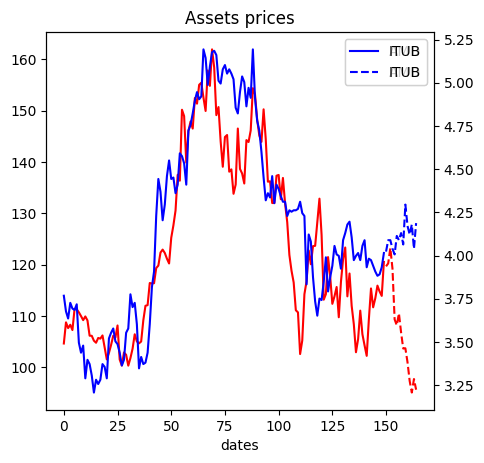

In [117]:
Analysis.plot_prediction()

# Displays the 5 best match

In [118]:
for value in sorted_Comparaison_150Length[:5]:
    print(value["reference_asset"],value["date_reference"],value["comparison_asset"],value["date_comparison"])

AMD 2021-08-20 15:30:00 ITUB 2020-09-09 15:30:00
AMD 2021-08-20 15:30:00 ITUB 2017-11-03 14:30:00
AMD 2021-08-20 15:30:00 ITUB 2021-03-12 15:30:00
AMD 2021-08-20 15:30:00 RIG 2016-09-29 15:30:00
AMD 2021-08-20 15:30:00 ITUB 2020-03-18 14:30:00


In [119]:
sorted_Comparaison_75Length = Analysis.comparison(symbol="AMD",data_length =75,timeframe=15)
for batch in range(1,5):
    Analysis.predict(sorted_Comparaison_75Length,batch)
    


1 : 56.886250148633266%
2 : 25.12170109472558%
3 : 24.43555346937383%
4 : 25.704041327003612%


Figure saved


/var/folders/k6/_mb6xsdj4_g0rcv39yljn9t00000gn/T/ipykernel_87010/4142165148.py:296: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  Figure.show()


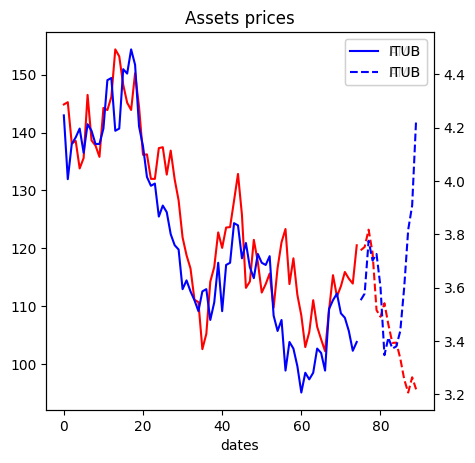

In [120]:
Analysis.plot_prediction()

In [121]:
for value in sorted_Comparaison_75Length[:5]:
    print(value["reference_asset"],value["date_reference"],value["comparison_asset"],value["date_comparison"])

AMD 2021-12-07 15:30:00 ITUB 2020-07-06 15:30:00
AMD 2021-12-07 15:30:00 TEVA 2019-01-15 15:30:00
AMD 2021-12-07 15:30:00 NOK 2015-12-21 15:30:00
AMD 2021-12-07 15:30:00 AAL 2015-04-02 15:30:00
AMD 2021-12-07 15:30:00 RIG 2016-12-21 15:30:00
